In [28]:
using Plots
using DataFrames
using CSV
using LaTeXStrings
using Clapeyron

In [29]:
model = SAFTgammaMie([("MEA",["NH2"=>1, "CH2"=>1, "CH2OH"=>1])];
#=  
    userlocations=(;
        Mw = [16.02, 14.03, 31.03],
        epsilon = [284.78 348.39 528.21;
                   348.39 473.39 423.17;
                   528.21 423.17 407.22],
        sigma = [3.2477, 4.8801, 3.4054],
        lambda_a = [6.000, 6.000, 6.000],
        lambda_r = [10.254, 19.871, 22.699],
        vst = [1.0, 1.0, 2.0],
        S = [0.79675, 0.22932, 0.58538],
        n_e=[1, 0, 2],
        n_H=[2, 0, 1],
        epsilon_assoc = Dict((("NH2","e"),("NH2","H")) => 1070.80,
                             (("NH2","e"),("CH2OH","H")) => 2403.78,
                             (("CH2OH","e"),("CH2OH","H")) => 2097.90,
                             (("CH2OH","e"),("NH2","H")) => 629.88),
        bondvol = Dict((("NH2","e"),("NH2","H")) => 95.225e-30,
                             (("NH2","e"),("CH2OH","H")) => 26.192e-30,
                             (("CH2OH","e"),("CH2OH","H")) => 62.309e-30,
                             (("CH2OH","e"),("NH2","H")) => 346.08e-30)
=#
    )#)

SAFTgammaMie{BasicIdeal} with 1 component:
 "MEA": "NH2" => 1, "CH2" => 1, "CH2OH" => 1
Group Type: SAFTgammaMie
Contains parameters: segment, shapefactor, lambda_a, lambda_r, sigma, epsilon, epsilon_assoc, bondvol

In [30]:
v0 = Clapeyron.x0_crit_pure(model)
(Tc,pc,vc) = crit_pure(model, big.(v0))

(674.7541929601080372996827871720784901459900891833407809866144262657380231433002, 8.049937546377226580940055903184338509260015529965370916543839575372448730446578e+06, 0.0002354623622763589367981103542644412479188704533505998119616059839560738832854673)

In [31]:
cp_exp = CSV.read("MEA_Heat_Capacity_Experimental.csv",
               header=[1, 2, 3],
               DataFrame);

In [32]:
N = 100
T = LinRange(273,Tc - 10.0,N)
sat_1 = saturation_pressure(model,T[1])
v0 = [sat_1[2],sat_1[3]]
p_liq = zeros(N)
p_vap = zeros(N)
cp_calc_liq = zeros(N)
cp_calc_vap = zeros(N)
cp_basic_ideal = zeros(N)
cp_ideal = zeros(N)
cp_model_liq = zeros(N)
cp_model_vap = zeros(N)

for i in 1:N
    global v0, p_liq, p_vap, cp_model_liq, cp_model_vap
    sat = saturation_pressure(model,T[i],v0=v0)
    v0 = [sat[2],sat[3]]
    p_liq[i] = sat[1] + 1.0
    p_vap[i] = sat[1] - 2.0
    if p_vap[i] < 0.0
       p_vap[i] = 0.0
    end
    cp_calc_liq[i] = isobaric_heat_capacity(model,p_liq[i],T[i])
    cp_calc_vap[i] = isobaric_heat_capacity(model,p_vap[i],T[i])
    cp_basic_ideal[i] = isobaric_heat_capacity(model,1e-10,T[i])
    cp_ideal[i] = 12.9 + 0.28*T[i] - 1.59e-4 * T[i]^2 + 3.34e-8 * T[i]^3
    cp_model_liq[i] = cp_calc_liq[i] - cp_basic_ideal[i] + cp_ideal[i]
    cp_model_vap[i] = cp_calc_vap[i] - cp_basic_ideal[i] + cp_ideal[i]
    if cp_model_vap[i] > 300.0
    end
end

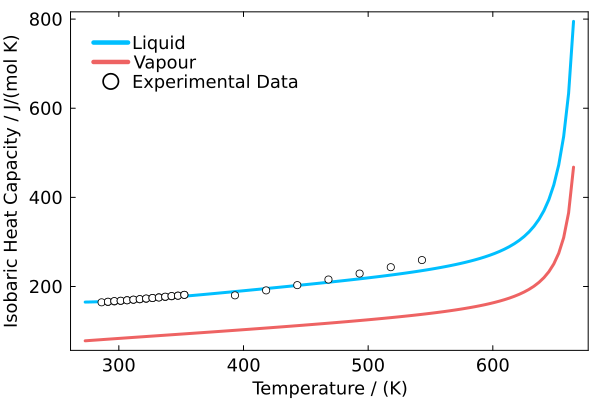

In [33]:
colours = ["indianred2", "deepskyblue1"]

plt = plot(grid = :off, 
           framestyle = :box, 
           foreground_color_legend = nothing, 
           legend_font = font(12),
           xtickfont = font(12),
           ytickfont = font(12))

plot!(plt,T,cp_model_liq,
    color=colours[2],
    line = (:path, 3),
    label = "Liquid")

plot!(plt,T,cp_model_vap,
    color=colours[1],
    line = (:path, 3),
    label = "Vapour")

plot!(plt, cp_exp[:, 1], cp_exp[:, 2], 
      seriestype = :scatter, 
      color = "white", 
      markerstrokecolor = "black", 
      line = (:scatter, 0.4), 
      label = "Experimental Data")


xlabel!(plt, "Temperature / (K)", xguidefontsize = 12)
ylabel!(plt, "Isobaric Heat Capacity / J/(mol K)", yguidefontsize = 12)